### Autor: Fernando Ordinola S.

## Preliminares

> __Formulación del problema__:  El problema planteado es un problema de clasificación binaria supervisada en el ámbito del procesamiento de lenguaje natural (NLP). El objetivo es clasificar los tweets en dos categorías, positiva o negativa, en función del sentimiento que expresan.
>
>El conjunto de datos consiste en un conjunto de tweets etiquetados con su respectiva emoción, lo que hace que este problema sea un problema de aprendizaje supervisado. Los tweets se consideran como características del modelo, mientras que la polaridad (positiva o negativa) se considera como la variable objetivo.
>
>Para resolver este problema, se pueden utilizar diferentes técnicas de aprendizaje automático, como clasificadores basados en árboles de decisión, redes neuronales, SVM, Naive Bayes, entre otros. Se pueden aplicar diferentes técnicas de preprocesamiento de texto, como limpieza de datos, normalización, tokenización, eliminación de stopwords, entre otras, para mejorar el rendimiento del modelo.
>
> __Objetivo__: Lograr un desempeño significativo en la clasificación de la polaridad de los tweets entregados haciendo uso de preprocesamiento, análisis de la naturaleza del lenguaje, y haciendo uso de posibles técnicas como lemmatización.
>
>
> __Implementación de la solución__: Se implementarán modelos de clasificación supervisada que según nuestro criterio pueden dar mejores resultados en el ambito de procesamiento de texto, pero para ello antes se hará limpieza de datos, preprocesamiento, eliminación de stopwords, procesos linguisticos como lo son la lemantización además de un análisis exploratorio para observar como se comportan los datos ante la aplicación de diferentes técnicas de preprocesamiento.

> __Métricas de desempeño__
>> - Exactitud
>> - Precisión
>> - Recall
>> - F1 Score

> __Modelos a utilizar__
>> - Naive Bayes
>> - SVC
>> - Logistic Regression
>> - Random Forest
>> - Gradient Boost

> __Estrategia de división de muestras__: Se usará train_test_split de la libreria Scikit-learn, La idea detrás de esta división es que el modelo se entrene con el conjunto de datos de entrenamiento y luego se pruebe con el conjunto de datos de prueba para medir su capacidad para generalizar a nuevos datos. De esta manera, podemos evitar el sobreajuste y la subestimación del modelo.

> __Tipo de pre procesamiento a utilizar__: Dado que se cuentan con pocas variables, se ajustaran diferentes variantes de la columna correspondientes a los tweets para que se ajusten mejor a la naturaleza de cada modelo, por ejemplo eliminar stopwords en un modelo naive bayes puede ser algo negativo ya que este depende de la distribución de tokens etc, por otra parte se probará con lemantización en diferentes niveles, ya sea aplicando a todos los tipos de palabras o solo aplicando a sustantivos y no a verbos ya que posiblemente un verbo puede ser determinante en el proposito de lo que se busca expresar en un tweet

## Aspectos Computacionales

> Python 3.9.12

> Librerías a utilizar
> - pandas 1.4.2
> - numpy 1.21.5
> - matplotlib 3.5.1
> - wordcloud 1.8.2.2
> - seaborn 0.11.2
> - sklearn 1.0.2
> - nltk 3.7
> - keras 2.11.0

Grillas

> LR
> - C = [0.1, 1, 10, 100]
> - max_iter = [100, 200, 250]

> Linear SVC
> - C = [0.1, 1, 10, 100]
> - max_iter = [1000, 5000, 10000]

> NB
> - alpha = [0.001, 0.01, 1, 10]
> - fit_prior = [True, False]

> GradientBoostingClassifier
> - n_estimators = [10, 50, 150, 250, 450]
> - max_depth = [3,6,8]
> - learning_rate = [0.1, 0.5, 1]

In [47]:
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
import re
from sklearn.ensemble import StackingClassifier
import random

import spacy
from wordcloud import WordCloud

plt.rcParams['figure.figsize'] = (10,7)

# Descarga de stopwords de NLTK
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ferna\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
df = pd.read_csv('training_tweets.csv').drop('Unnamed: 0', axis=1)

# Feature Engineering

In [5]:
df['content'] = df['content'].str.lower() #transformamos todos los tweets a lowercase.

<html>_________________________________________________________________________________________________________________________ </html>

In [6]:
df.isnull().sum()

content      0
sentiment    0
dtype: int64

<html>_________________________________________________________________________________________________________________________ </html>

In [11]:
nlp = spacy.load('en_core_web_sm')

def lemmatize_tweet(tweet):
    doc = nlp(tweet)
    lemmatized_tokens = [token.lemma_ for token in doc]
    return " ".join(lemmatized_tokens)

In [12]:
def delete_usr_mention(tweet):
    tweet_no_user = re.sub(r"@\w+[.:;]?", "", tweet)
    return tweet_no_user

In [13]:
def remove_urls(text):
    url_pattern = re.compile(r'http\S+')
    return url_pattern.sub(r'', text)

In [16]:
df['content'] = df['content'].apply(delete_usr_mention)

In [17]:
df['content'] = df['content'].apply(lambda x: remove_urls(x))

No quedaron celdas vacias, así que se puede observar que las url que se eliminaron de los tweets siempre venian acompañadas por algun mensaje del usuario

In [18]:
df.loc[df['content'].isnull()]

,content,sentiment


In [19]:
df['lemmatized_tweets'] = df['content'].apply(lemmatize_tweet)

In [20]:
df.head()

,content,sentiment,lemmatized_tweets
0,happy mama's day to all mothers,love,happy mama 's day to all mother
1,i am lost. please help me find a good home.,worry,I be lose . please help I find a good home .
2,"yes yes i am, networking whore to the fullest...",happiness,"yes yes I be , network whore to the full ......"
3,you wish that would have been your tweet after...,neutral,you wish that would have be your tweet after y...
4,now i am doing the microeconomics project iha...,worry,now I be do the microeconomics project ihate...


<html>_________________________________________________________________________________________________________________________ </html>

#### Recodificación

In [21]:
positive_s = ["happiness", 'love', 'surprise', 'fun', 'relief', 'enthusiasm']
negative_s = ["worry", 'sadness', 'hate', 'empty', 'boredom', 'anger']

pos_d = {x:'Positive' for x in positive_s}
neg_d = {x:'Negative' for x in negative_s}

pos_d.update(neg_d)

In [22]:
df["polarity"] = df["sentiment"].replace(pos_d)
df_no_neutral = df[df["polarity"] != 'neutral']

In [23]:
df.polarity.value_counts('%')

Negative    0.400733
Positive    0.384233
neutral     0.215033
Name: polarity, dtype: float64

> Como se puede observar los neutrales son un 21% de los sentimientos, y si recodificamos aleatoriamiente lo más probable a criterio es que se empeore el desempeño, por lo que primero probaremos con un naive bayes para testear el desempeño sin considerar los neutrales y luego haremos lo mismo recodificando neutrales aleatoriamente para comparar cuanto se empeora el desempeño, __para posteriormente proponer una solución a este problema__

##### Modelo entrenado solo con positive & negative, excluyendo neutral (Recod)

In [66]:
X_train, X_test, y_train, y_test = train_test_split(df_no_neutral['lemmatized_tweets'], 
                                                    df_no_neutral['polarity'], test_size=0.33, random_state=11238)

In [67]:
pipeline = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('classifier', MultinomialNB())
])

In [68]:
pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_test)

In [69]:
print("\nReporte de Clasificación:")
print(classification_report(y_test, predictions))


Reporte de Clasificación:
              precision    recall  f1-score   support

    Negative       0.72      0.79      0.75      4009
    Positive       0.75      0.67      0.70      3763

    accuracy                           0.73      7772
   macro avg       0.73      0.73      0.73      7772
weighted avg       0.73      0.73      0.73      7772



In [70]:
pipeline.set_params(classifier=BernoulliNB(alpha=2, binarize=0.0))

Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('classifier', BernoulliNB(alpha=2))])

In [71]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('classifier', BernoulliNB(alpha=2))])

In [72]:
predictions_bnb = pipeline.predict(X_test)
print("\nReporte de Clasificación para BernoulliNB:")
print(classification_report(y_test, predictions_bnb))


Reporte de Clasificación para BernoulliNB:
              precision    recall  f1-score   support

    Negative       0.72      0.78      0.75      4009
    Positive       0.74      0.68      0.71      3763

    accuracy                           0.73      7772
   macro avg       0.73      0.73      0.73      7772
weighted avg       0.73      0.73      0.73      7772



> Ahora probamos recodificando de forma aleatoria 

In [73]:
mask = df['polarity'] == 'neutral'
neutral_indices = np.where(mask)[0]

In [74]:
df['polarity_neutral_random'] = df['polarity']

for row in neutral_indices:
    df['polarity_neutral_random'].iloc[row] = random.choice(['Positive', 'Negative'])
        

In [75]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(df['lemmatized_tweets'], df['polarity_neutral_random'], 
                                                    test_size = 0.33, random_state = 11238)

In [76]:
pipeline.fit(X_train_2, y_train_2)

Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('classifier', BernoulliNB(alpha=2))])

In [77]:
y_bnb = pipeline.predict(X_test_2)

In [78]:
print("\nReporte de Clasificación:")
print(classification_report(y_test_2, y_bnb))


Reporte de Clasificación:
              precision    recall  f1-score   support

    Negative       0.66      0.72      0.69      4935
    Positive       0.69      0.62      0.66      4965

    accuracy                           0.67      9900
   macro avg       0.67      0.67      0.67      9900
weighted avg       0.67      0.67      0.67      9900



> Como se puede observar, era de esperar que el desempeño bajase considerablemente aleatorizando la recodificación de los neutrales, por lo que se propone usar el primer BernoulliNB que se entrenó sin neutrales, para predecir la polaridad de los neutrales y recodificar de acuerdo a eso

In [81]:
pipeline.fit(X_train, y_train)
new_recod = pipeline.predict(df[df['polarity'] == 'neutral']['lemmatized_tweets'])

In [82]:
mask = df['polarity'] == 'neutral'
neutral_values = df['polarity'][mask]
neutral_indices = np.where(mask)[0]

In [83]:
# Recodificamos los neutrales con las predicciones del modelo 
df['new_polarity'] = df['polarity']
for index, row in enumerate(neutral_indices):
    df['new_polarity'].iloc[row] = new_recod[index]

> Ahora entrenamos un modelo con las nuevas polaridades entregadas por nuestro BernoulliNB, y observamos la mejora en rendimiento obtenida..

In [85]:
X_train, X_test, y_train, y_test = train_test_split(df['lemmatized_tweets'], df['new_polarity'], 
                                                    test_size = 0.33, random_state = 11238)

In [87]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('classifier', BernoulliNB(alpha=2))])

In [88]:
predictions_bnb = pipeline.predict(X_test)

In [89]:
print("\nReporte de Clasificación:")
print(classification_report(y_test, predictions_bnb))


Reporte de Clasificación:
              precision    recall  f1-score   support

    Negative       0.74      0.80      0.77      4944
    Positive       0.78      0.72      0.75      4956

    accuracy                           0.76      9900
   macro avg       0.76      0.76      0.76      9900
weighted avg       0.76      0.76      0.76      9900



> Como podemos evidenciar, __en vez de recodificar los neutrales aleatoriamente__, los recodificamos con las predicciones que hacía nuestro modelo de Naive Bayes, el cual tenía una precisión del 73% y se había entrenado solo con los tweets positivos y negativos. Luego, estas predicciones reemplazaron a los valores neutrales y se entrenó un nuevo modelo que incluyó los valores ya recodificados. Como resultado, se observó una mejora en diversas métricas de desempeño.

<html>_________________________________________________________________________________________________________________________ </html>

#### Eliminación de palabras comunes

In [90]:
stop_words = stopwords.words('english')

In [91]:
count_vect = CountVectorizer(stop_words='english', strip_accents='ascii', max_df=0.90, min_df=0.05, max_features=100)

In [92]:
count_matrix = count_vect.fit_transform(df['lemmatized_tweets'])

In [93]:
count_df = pd.DataFrame(count_matrix.toarray(), columns=count_vect.get_feature_names_out())

In [94]:
df = pd.concat([df, count_df], axis=1)

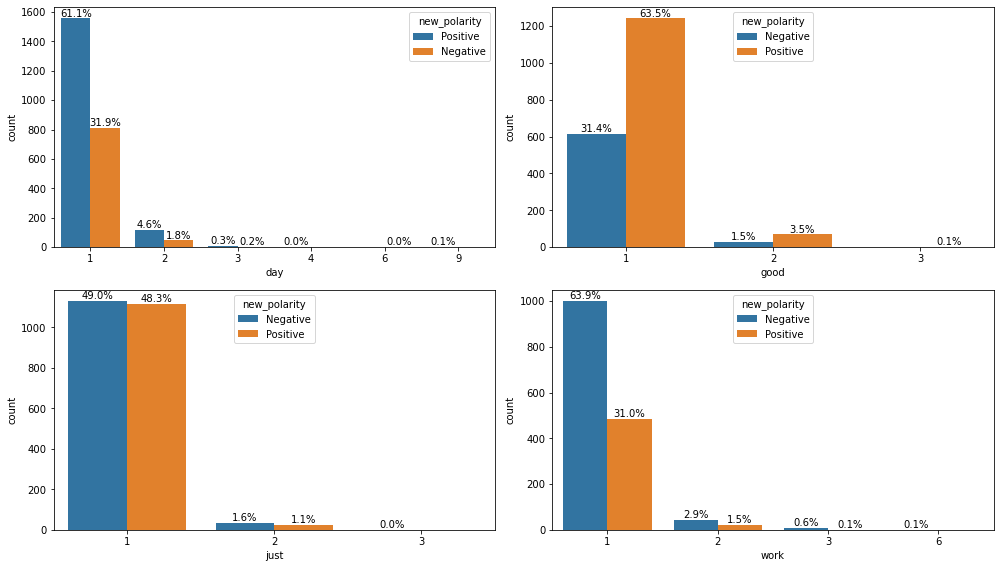

In [95]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))

for ax, col in zip(axes.flatten(), count_vect.get_feature_names_out()):
    sns.countplot(data=df[df[col] > 0], x=col, hue='new_polarity', ax=ax)
    
    heights = np.nan_to_num([p.get_height() for p in ax.patches])
    total = sum(heights)
    for p in ax.patches:
        ax.annotate(f'{p.get_height()/total:.1%}', (p.get_x()+p.get_width()/2, p.get_height()), ha='center', va='bottom')
fig.tight_layout()

plt.show()

> Veemos que estas palabras más usadas en tweets obtenidas por el countvectorizer, pueden aportar a la decisión de un modelo para decidir que polaridad son, por lo que por criterio de investigación decidimos dejarlas, a __excepción__ de __just__ que podemos ver que la diferencia es marginal, y no estaría aportando a la decisión, así que se descarta.

In [96]:
df['lemmatized_tweets'] = df['lemmatized_tweets'].str.replace('just', '')

<html>_________________________________________________________________________________________________________________________ </html>

In [97]:
tokens = [word_tokenize(message) for message in df['lemmatized_tweets']] 

In [98]:
frequency_dist = FreqDist(token for tokens_list in tokens for token in tokens_list)

In [99]:
filtered_d = {k: v for k, v in frequency_dist.items() if len(k) > 1}

<html>_________________________________________________________________________________________________________________________ </html>

# EDA

#### Datos nulos

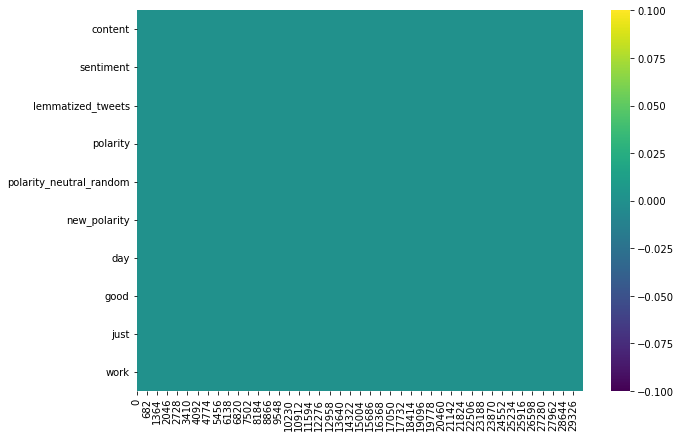

In [102]:
sns.heatmap(df.isnull().transpose(), cmap='viridis');

> Dataset sin valores nulos.

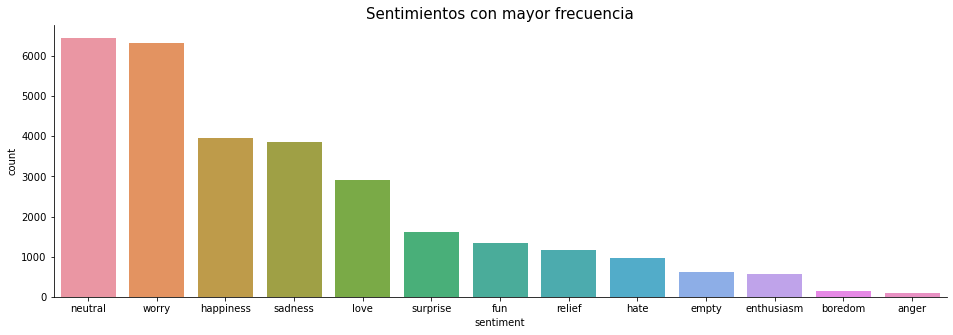

In [336]:
fig, ax = plt.subplots(figsize= (16,5))
plt.title('Sentimientos con mayor frecuencia', fontsize=15)
sns.countplot(data=df, x='sentiment', order=df.sentiment.value_counts().index)
sns.despine()

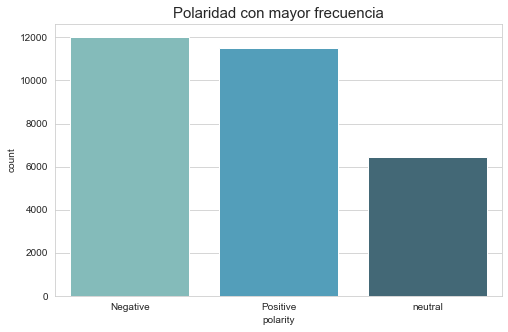

In [105]:
sns.set_style('whitegrid')
color_palette = 'GnBu_d'

fig, ax = plt.subplots(figsize=(8, 5))
sns.countplot(data=df, x='polarity', order=df['polarity'].value_counts().index, palette=color_palette)
ax.set_title('Polaridad con mayor frecuencia', fontsize=15)

plt.show()

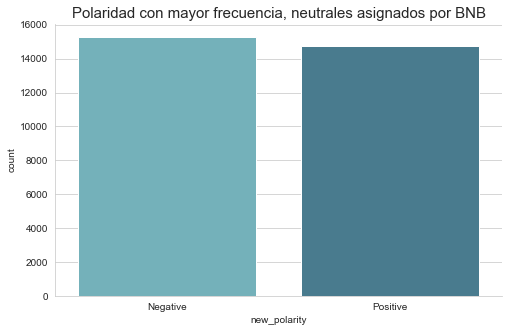

In [111]:
fig, ax = plt.subplots(figsize= (8,5))
plt.title('Polaridad con mayor frecuencia, neutrales asignados por BNB', fontsize=15)
sns.countplot(data=df, x='new_polarity', order=df.new_polarity.value_counts().index, palette=color_palette)
sns.despine()

plt.show()

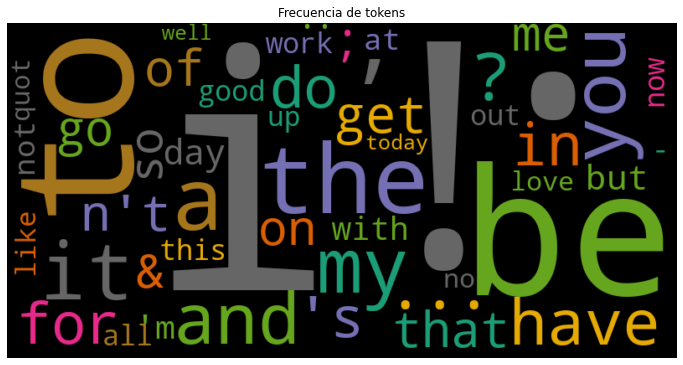

In [339]:
wordcloud = WordCloud(width=800, height=400, background_color='black', max_words=50, relative_scaling=0.5, colormap='Dark2')

wordcloud.generate_from_frequencies(frequency_dist)

plt.figure(figsize=(12, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Frecuencia de tokens')
plt.show()

# Separación

In [124]:
df['new_polarity'] = df['new_polarity'].replace(['Positive', 'Negative'], [1,0])

In [125]:
X_train, X_test, y_train, y_test = train_test_split(df['lemmatized_tweets'], df['new_polarity'], test_size = 0.33, random_state = 11238)

In [126]:
vectorizer = CountVectorizer()

train_vectors = vectorizer.fit_transform(X_train)
test_vectors = vectorizer.transform(X_test)

# MultinomialNB

In [127]:
param_grid = dict(
    alpha = [0.01, 0.1, 1, 10],
    fit_prior = [True, False]
    )

MNB = MultinomialNB()

GSearch_MNB = GridSearchCV(MNB, param_grid, cv=5)
GSearch_MNB.fit(train_vectors, y_train)

predictions_mnb = GSearch_MNB.predict(test_vectors)

print("Mejores hiperparámetros:", GSearch_MNB.best_params_)
print("Precisión en conjunto de prueba:", GSearch_MNB.score(test_vectors, y_test))

Mejores hiperparámetros: {'alpha': 1, 'fit_prior': False}
Precisión en conjunto de prueba: 0.7537373737373737


In [128]:
print("\nReporte de Clasificación:")
print(classification_report(y_test, predictions_mnb))


Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.72      0.82      0.77      4944
           1       0.79      0.69      0.74      4956

    accuracy                           0.75      9900
   macro avg       0.76      0.75      0.75      9900
weighted avg       0.76      0.75      0.75      9900



# SVM

In [129]:
svc = SVC()

param_grid_svc = {'C': [0.1, 0.3, 0.5], 'kernel': ['linear', 'rbf']}

svc_model = GridSearchCV(svc, param_grid=param_grid_svc, cv=5)
svc_model.fit(train_vectors, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 0.3, 0.5], 'kernel': ['linear', 'rbf']})

In [130]:
print("Mejores parámetros: ",svc_model.best_params_)
print("Precisión del modelo: ", svc_model.best_score_)

Mejores parámetros:  {'C': 0.1, 'kernel': 'linear'}
Precisión del modelo:  0.7645273631840797


In [131]:
svc_predictions = svc_model.predict(test_vectors)

In [132]:
print(classification_report(y_test, svc_predictions))

              precision    recall  f1-score   support

           0       0.75      0.79      0.77      4944
           1       0.78      0.74      0.76      4956

    accuracy                           0.77      9900
   macro avg       0.77      0.77      0.77      9900
weighted avg       0.77      0.77      0.77      9900



# Gradient Boosting

In [135]:
param_grid_gbc = {
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 150],
}

In [136]:
gbc = GradientBoostingClassifier(random_state=1)

In [138]:
grid_search = GridSearchCV(estimator=gbc, param_grid=param_grid_gbc, cv=5, scoring='f1')

In [139]:
grid_search.fit(train_vectors, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=1),
             param_grid={'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [50, 100, 150]},
             scoring='f1')

In [140]:
gb_best_m = GradientBoostingClassifier(**grid_search.best_params_, random_state=1)

In [141]:
gb_best_m.fit(train_vectors, y_train)

GradientBoostingClassifier(learning_rate=0.2, max_depth=7, n_estimators=150,
                           random_state=1)

In [142]:
predictions_gbc = gb_best_m.predict(test_vectors)

In [143]:
print('Mejores hiperparámetros:', grid_search.best_params_)

Mejores hiperparámetros: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 150}


In [144]:
print("\nReporte de Clasificación:")
print(classification_report(y_test, predictions_gbc, digits=4))


Reporte de Clasificación:
              precision    recall  f1-score   support

           0     0.7335    0.7656    0.7492      4944
           1     0.7555    0.7226    0.7387      4956

    accuracy                         0.7440      9900
   macro avg     0.7445    0.7441    0.7439      9900
weighted avg     0.7445    0.7440    0.7439      9900



# Logistic Regression

In [145]:
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga']
}

In [146]:
lr = LogisticRegression(random_state=1, max_iter=15000)

In [147]:
lr_model = GridSearchCV(lr, param_grid_lr, cv=5)
lr_model.fit(train_vectors, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=15000, random_state=1),
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'solver': ['liblinear', 'saga']})

In [148]:
print('Mejores parámetros:', lr_model.best_params_)

Mejores parámetros: {'C': 0.1, 'solver': 'liblinear'}


In [149]:
predictions_lr = lr_model.predict(test_vectors)

In [150]:
print(classification_report(y_test, predictions_lr))

              precision    recall  f1-score   support

           0       0.75      0.79      0.77      4944
           1       0.78      0.74      0.76      4956

    accuracy                           0.77      9900
   macro avg       0.77      0.77      0.77      9900
weighted avg       0.77      0.77      0.77      9900



# BernouliNB

In [151]:
parameters = {
    'alpha': [0.1, 1.0, 10.0] 
}

In [152]:
clf = BernoulliNB()

In [153]:
bernoulli_m = GridSearchCV(clf, parameters, cv=5, n_jobs=-1, verbose=1)

In [154]:
bernoulli_m.fit(train_vectors, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


GridSearchCV(cv=5, estimator=BernoulliNB(), n_jobs=-1,
             param_grid={'alpha': [0.1, 1.0, 10.0]}, verbose=1)

In [155]:
bernoulli_predictions = bernoulli_m.predict(test_vectors)

In [156]:
print(classification_report(y_test, bernoulli_predictions, digits=4))

              precision    recall  f1-score   support

           0     0.7444    0.7874    0.7653      4944
           1     0.7749    0.7302    0.7519      4956

    accuracy                         0.7588      9900
   macro avg     0.7597    0.7588    0.7586      9900
weighted avg     0.7597    0.7588    0.7586      9900



In [157]:
print("Best parameters: ", bernoulli_m.best_params_)

Best parameters:  {'alpha': 1.0}


# Tabla comparativa modelos

In [158]:
models = {'MultinomialNB': GSearch_MNB, 
          'SVC': svc_model, 
          'Gradient Boost': gb_best_m, 
          'LogisticRegression': lr_model, 
          'BernoulliNB': bernoulli_m}

accuracies = {}
for name, model in models.items():
    accuracy = model.score(test_vectors, y_test)
    accuracies[name] = accuracy

df_comparison = pd.DataFrame.from_dict(accuracies, orient='index', columns=['Accuracy'])
df_comparison.index.name = 'Model'

In [159]:
df_comparison.sort_values(by='Accuracy', ascending=False)

,Accuracy
Model,
SVC,0.766162
LogisticRegression,0.765455
BernoulliNB,0.758788
MultinomialNB,0.753737
Gradient Boost,0.744040


> Los dos mejores modelos SVC y LogisticRegression respectivamente

## Exportación de modelos

In [533]:
import pickle

In [534]:
with open('multinomialnb_tweet.pkl', 'wb') as archive:
    pickle.dump(Search_MNB_1, archive)

In [535]:
with open('svc_tweet.pkl', 'wb') as archive:
    pickle.dump(svc_model, archive)